In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Retrieving the last values

In [2]:
traffic_reel = pd.read_csv('to_predict_traffic.csv', delimiter = ';') # do we want older or more recent data ?
traffic_reel = traffic_reel[traffic_reel["Libelle noeud amont"].isin(['Av_Champs_Elysees-Washington'])]
traffic_reel = traffic_reel[traffic_reel["Libelle noeud aval"].isin(['Av_Champs_Elysees-Berri']) ]
traffic_reel["Date et heure de comptage"] = pd.to_datetime(traffic_reel["Date et heure de comptage"], utc=True)
traffic_reel = traffic_reel[["Date et heure de comptage", "Débit horaire"]].sort_values(by=["Date et heure de comptage"], ascending=True)
traffic_reel = traffic_reel.drop(traffic_reel.index[0])
traffic_reel = traffic_reel.rename(columns={"Débit horaire": "Real Debit"})

traffic_reel


,Date et heure de comptage,Real Debit
276,2023-12-01 00:00:00+00:00,857.0
285,2023-12-01 01:00:00+00:00,685.0
284,2023-12-01 02:00:00+00:00,694.0
40,2023-12-01 03:00:00+00:00,636.0
39,2023-12-01 04:00:00+00:00,438.0
...,...,...
85,2023-12-03 18:00:00+00:00,1464.0
130,2023-12-03 19:00:00+00:00,1385.0
84,2023-12-03 20:00:00+00:00,1200.0
129,2023-12-03 21:00:00+00:00,1266.0


# Creating a Baseline Model

In [4]:
traffic_final_imp = pd.read_csv('traffic_final.csv', delimiter = ',') # do we want older or more recent data ?
traffic_final_imp = traffic_final_imp.rename(columns={"timestamp":"Date et heure de comptage"})
traffic_final_imp.head()

,Unnamed: 0,Date et heure de comptage,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,...,number_markets,ongoing_market,cos_week,sin_week,cos_weekday,sin_weekday,cos_year_day,sin_year_day,cos_timestamp_hour,sin_timestamp_hour
0,0,2023-02-01 22:00:00+00:00,4264,AV_Champs_Elysees,764.0,11.28000,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,2.0,0,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,0.866025,-0.500000
1,1,2023-02-01 21:00:00+00:00,4264,AV_Champs_Elysees,819.0,16.52056,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,2.0,0,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,0.707107,-0.707107
2,2,2023-02-01 19:00:00+00:00,4264,AV_Champs_Elysees,1082.0,19.98722,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,2.0,1,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,0.258819,-0.965926
3,3,2023-02-01 17:00:00+00:00,4264,AV_Champs_Elysees,1027.0,23.27334,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,2.0,1,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,-0.258819,-0.965926
4,4,2023-08-09 22:00:00+00:00,191,Sts_Peres,257.0,3.04445,Fluide,114,Sts_Peres-Voltaire,119,...,1.0,0,-0.748511,-0.663123,-0.900969,-0.433884,-0.788305,-0.615285,0.866025,-0.500000


In [6]:
champs = traffic_final_imp[traffic_final_imp['Libelle'] == "AV_Champs_Elysees"].sort_values(by=["Date et heure de comptage"], ascending=True)
champs.head()

,Unnamed: 0,Date et heure de comptage,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,...,number_markets,ongoing_market,cos_week,sin_week,cos_weekday,sin_weekday,cos_year_day,sin_year_day,cos_timestamp_hour,sin_timestamp_hour
7299,7299,2022-11-01 03:00:00+00:00,4264,AV_Champs_Elysees,672.0,8.89223,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,7.071068e-01,0.707107
7298,7298,2022-11-01 04:00:00+00:00,4264,AV_Champs_Elysees,513.0,7.12889,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,5.000000e-01,0.866025
7297,7297,2022-11-01 05:00:00+00:00,4264,AV_Champs_Elysees,494.0,6.22500,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,2.588190e-01,0.965926
8665,8665,2022-11-01 06:00:00+00:00,4264,AV_Champs_Elysees,513.0,5.80723,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,1,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,6.123234e-17,1.000000
7296,7296,2022-11-01 07:00:00+00:00,4264,AV_Champs_Elysees,484.0,5.57111,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,1,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,-2.588190e-01,0.965926


In [7]:
class BaselineAverage:
    def __init__(self):
        self.average_value = None

    def fit(self, time_series):
        # Calculate the average value of the time series
        self.average_value = time_series.mean()

    def predict(self, forecast_dates):
        # Check if the model has been fitted
        if self.average_value is None:
            raise ValueError("Model has not been fitted. Call fit() first.")

        # Create a DataFrame with forecast dates and corresponding average value predictions
        forecast_df = pd.DataFrame({
            'Date et heure de comptage': forecast_dates,
            'Débit horaire': [self.average_value] * len(forecast_dates)
        })
        forecast_df["Date et heure de comptage"] = pd.to_datetime(forecast_df["Date et heure de comptage"], utc=True)

        return forecast_df

In [8]:
baseline_model = BaselineAverage()
baseline_model.fit(champs['Débit horaire'])

In [9]:
date_range = pd.date_range(start='2023-12-01', end='2023-12-04', freq='H')

formatted_dates = date_range.strftime('%Y-%m-%dT%H:%M:%S%z')

predictions = baseline_model.predict(formatted_dates)

predictions

,Date et heure de comptage,Débit horaire
0,2023-12-01 00:00:00+00:00,884.490328
1,2023-12-01 01:00:00+00:00,884.490328
2,2023-12-01 02:00:00+00:00,884.490328
3,2023-12-01 03:00:00+00:00,884.490328
4,2023-12-01 04:00:00+00:00,884.490328
...,...,...
68,2023-12-03 20:00:00+00:00,884.490328
69,2023-12-03 21:00:00+00:00,884.490328
70,2023-12-03 22:00:00+00:00,884.490328
71,2023-12-03 23:00:00+00:00,884.490328


In [23]:
predictions_without = predictions.drop(predictions.index[-2:])

merged_df = pd.merge(traffic_reel, predictions_without, on='Date et heure de comptage')

# Calculate the Mean Squared Error
mse = mean_squared_error(merged_df['Débit horaire'], merged_df['Real Debit'])
rmse = math.sqrt(mse)
print(rmse)

452.7154091167117


In [10]:
traffic_reel_formatted = traffic_reel.rename(columns={"Real Debit":"Débit horaire"})
reel_values = pd.concat([champs[['Débit horaire', 'Date et heure de comptage']], traffic_reel_formatted], ignore_index=True)
reel_values["Date et heure de comptage"] = pd.to_datetime(reel_values["Date et heure de comptage"], utc=True)

reel_values


,Débit horaire,Date et heure de comptage
0,672.0,2022-11-01 03:00:00+00:00
1,513.0,2022-11-01 04:00:00+00:00
2,494.0,2022-11-01 05:00:00+00:00
3,513.0,2022-11-01 06:00:00+00:00
4,484.0,2022-11-01 07:00:00+00:00
...,...,...
9380,1464.0,2023-12-03 18:00:00+00:00
9381,1385.0,2023-12-03 19:00:00+00:00
9382,1200.0,2023-12-03 20:00:00+00:00
9383,1266.0,2023-12-03 21:00:00+00:00


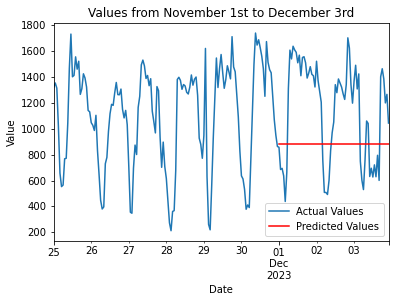

In [25]:
start_date = '2023-11-25'
end_date = '2023-12-04'
df_filtered = reel_values[(reel_values['Date et heure de comptage'] >= start_date) & (reel_values['Date et heure de comptage'] <= end_date)]


ax = df_filtered.plot(x='Date et heure de comptage', y='Débit horaire', kind='line', label='Actual Values', linestyle='-')

predictions_without.plot(x='Date et heure de comptage', y='Débit horaire', kind='line', label='Predicted Values', linestyle='-', color='red', ax=ax)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Values from November 1st to December 3rd')
plt.show()

# Testing an XG Boost Model

In [26]:
champs.head()

,Unnamed: 0,Date et heure de comptage,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,...,number_markets,ongoing_market,cos_week,sin_week,cos_weekday,sin_weekday,cos_year_day,sin_year_day,cos_timestamp_hour,sin_timestamp_hour
7299,7299,2022-11-01 03:00:00+00:00,4264,AV_Champs_Elysees,672.0,8.89223,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,7.071068e-01,0.707107
7298,7298,2022-11-01 04:00:00+00:00,4264,AV_Champs_Elysees,513.0,7.12889,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,5.000000e-01,0.866025
7297,7297,2022-11-01 05:00:00+00:00,4264,AV_Champs_Elysees,494.0,6.22500,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,2.588190e-01,0.965926
8665,8665,2022-11-01 06:00:00+00:00,4264,AV_Champs_Elysees,513.0,5.80723,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,1,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,6.123234e-17,1.000000
7296,7296,2022-11-01 07:00:00+00:00,4264,AV_Champs_Elysees,484.0,5.57111,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,1,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,-2.588190e-01,0.965926


In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    if isinstance(data, pd.Series):
        data = pd.DataFrame(data)
    
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    cols = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    new_cols = [f'Débit Horaire lag {i}' for i in range(1, len(agg.columns) + 1)]
    agg.columns = new_cols
    
    return agg

n_lags = 24
lags = series_to_supervised(champs['Débit horaire'], n_lags, 0)

champs_fr_removed = champs.iloc[n_lags:, :]

champs_with_lags = pd.concat([champs_fr_removed, lags], axis=1)

champs_with_lags

,Unnamed: 0,Date et heure de comptage,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,...,Débit Horaire lag 15,Débit Horaire lag 16,Débit Horaire lag 17,Débit Horaire lag 18,Débit Horaire lag 19,Débit Horaire lag 20,Débit Horaire lag 21,Débit Horaire lag 22,Débit Horaire lag 23,Débit Horaire lag 24
2138,2138,2022-11-02 03:00:00+00:00,4264,AV_Champs_Elysees,212.0,2.70555,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1149.0,1123.0,1018.0,933.0,833.0,780.0,705.0,667.0,465.0,268.0
6566,6566,2022-11-02 04:00:00+00:00,4264,AV_Champs_Elysees,156.0,2.40056,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1123.0,1018.0,933.0,833.0,780.0,705.0,667.0,465.0,268.0,212.0
2137,2137,2022-11-02 05:00:00+00:00,4264,AV_Champs_Elysees,283.0,3.24278,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1018.0,933.0,833.0,780.0,705.0,667.0,465.0,268.0,212.0,156.0
2136,2136,2022-11-02 06:00:00+00:00,4264,AV_Champs_Elysees,602.0,6.90889,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,933.0,833.0,780.0,705.0,667.0,465.0,268.0,212.0,156.0,283.0
6565,6565,2022-11-02 07:00:00+00:00,4264,AV_Champs_Elysees,887.0,16.74389,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,833.0,780.0,705.0,667.0,465.0,268.0,212.0,156.0,283.0,602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26848,26848,2023-11-30 19:00:00+00:00,4264,AV_Champs_Elysees,1433.0,30.87000,Saturé,2294,Av_Champs_Elysees-Washington,2293,...,1740.0,1647.0,1688.0,1627.0,1561.0,1465.0,1251.0,1674.0,1514.0,1457.0
22548,22548,2023-11-30 20:00:00+00:00,4264,AV_Champs_Elysees,1253.0,24.38111,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,1647.0,1688.0,1627.0,1561.0,1465.0,1251.0,1674.0,1514.0,1457.0,1433.0
22547,22547,2023-11-30 21:00:00+00:00,4264,AV_Champs_Elysees,1069.0,20.40723,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,1688.0,1627.0,1561.0,1465.0,1251.0,1674.0,1514.0,1457.0,1433.0,1253.0
26847,26847,2023-11-30 22:00:00+00:00,4264,AV_Champs_Elysees,950.0,16.66334,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,1627.0,1561.0,1465.0,1251.0,1674.0,1514.0,1457.0,1433.0,1253.0,1069.0


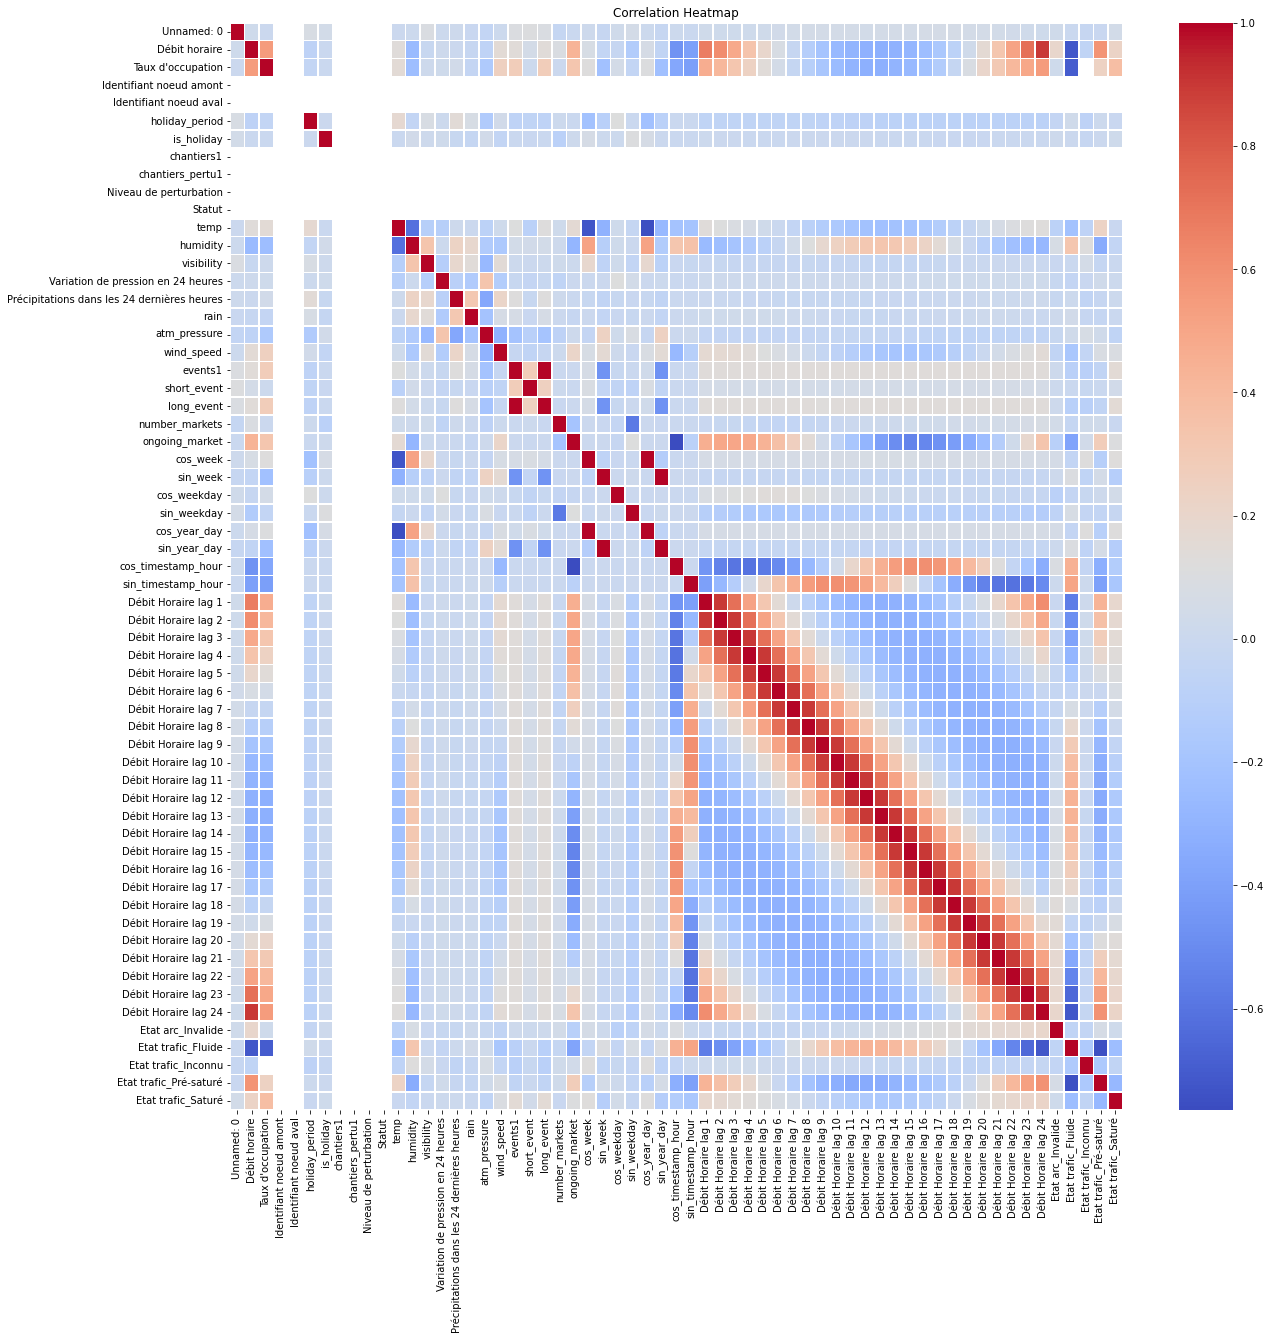

In [28]:
champs_numeric = champs_with_lags.drop(columns=['Libelle', 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week'], errors='ignore')

champs_numeric = pd.get_dummies(champs_numeric, columns=['Etat arc', 'Etat trafic'], drop_first=True)
correlation_matrix = champs_numeric.corr()

# Create a heatmap
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [14]:
def series_to_supervised_reduced(data, dropnan=True):
    if isinstance(data, pd.Series):
        data = pd.DataFrame(data)
    
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    cols = list()
    
    # input sequence (t-n, ... t-1)
    
    cols.append(data.shift(1))
    cols.append(data.shift(12))
    cols.append(data.shift(24))
    cols.append(data.shift(168))
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    
        
    new_cols = [f'Débit Horaire lag {i}' for i in range(1, len(agg.columns) + 1)]
    agg.columns = new_cols
    
    agg = agg.iloc[168:,:]
    
    return agg

In [183]:
champs['Débit horaire'] = champs['Débit horaire'].interpolate(method='linear')
champs["Taux d'occupation"] = champs["Taux d'occupation"].interpolate(method='linear')
champs["temp"] = champs["temp"].interpolate(method='linear')
champs["humidity"] = champs["humidity"].interpolate(method='linear')
champs["visibility"] = champs["visibility"].interpolate(method='linear')
champs["Variation de pression en 24 heures"] = champs["Variation de pression en 24 heures"].interpolate(method='linear')
champs["Précipitations dans les 24 dernières heures"] = champs["Précipitations dans les 24 dernières heures"].interpolate(method='linear')
champs["rain"] = champs["rain"].interpolate(method='linear')
champs["atm_pressure"] = champs["atm_pressure"].interpolate(method='linear')
champs["wind_speed"] = champs["wind_speed"].interpolate(method='linear')

lags = series_to_supervised_reduced(champs['Débit horaire'])

champs_fr_removed = champs.iloc[168:, :]

champs_with_lags = pd.concat([champs_fr_removed, lags], axis=1)

champs_numeric = champs_with_lags.drop(columns=['Libelle', 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week'], errors='ignore')

champs_numeric = pd.get_dummies(champs_numeric, columns=['Etat arc', 'Etat trafic'], drop_first=True)


In [187]:
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    testX, testy = test.drop(columns=["Débit horaire", "Taux d'occupation"], errors='ignore'), test['Débit horaire']
    
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX_row = testX.iloc[i,:]
        testy_row = testy.iloc[i]

        
        # fit model on history and make a prediction
        yhat = xgboost_forecast(train, testX_row)
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy_row, yhat))
        
    # estimate prediction error
    error = mean_squared_error(testy, predictions)
    return error, testy, predictions


In [184]:
def xgboost_forecast(train, testX):

    # split into input and output columns
    trainX, trainy = train.drop(columns=["Débit horaire", "Taux d'occupation"], errors='ignore'), train['Débit horaire']
    
    trainX = np.asarray(trainX)
    trainy = np.asarray(trainy)
    
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [185]:
def train_test_split(data, n_test):
    return data.iloc[:-n_test, :], data.iloc[-n_test:, :]

In [92]:
mae, y, yhat = walk_forward_validation(champs_numeric, 72)
print('MAE: %.3f' % mae)


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat
<ipython-input-89-bf7755a0bd4e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[len(train)] = new_row


>expected=615.0, predicted=503.2


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat
<ipython-input-89-bf7755a0bd4e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[len(train)] = new_row


>expected=439.0, predicted=391.7


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat
<ipython-input-89-bf7755a0bd4e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[len(train)] = new_row


>expected=273.0, predicted=402.7


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat
<ipython-input-89-bf7755a0bd4e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[len(train)] = new_row


>expected=212.0, predicted=195.0


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat
<ipython-input-89-bf7755a0bd4e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[len(train)] = new_row


>expected=361.0, predicted=207.5


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat
<ipython-input-89-bf7755a0bd4e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[len(train)] = new_row


>expected=367.0, predicted=574.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat
<ipython-input-89-bf7755a0bd4e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[len(train)] = new_row


>expected=677.0, predicted=732.7


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat
<ipython-input-89-bf7755a0bd4e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[len(train)] = new_row


>expected=1381.0, predicted=1119.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat
<ipython-input-89-bf7755a0bd4e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[len(train)] = new_row


>expected=1398.0, predicted=1473.7


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1374.0, predicted=1469.0


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1305.0, predicted=1429.4


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1342.0, predicted=1316.7


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1331.0, predicted=1357.6


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1282.0, predicted=1382.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1269.0, predicted=1395.7


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1322.0, predicted=1306.0


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1416.0, predicted=1259.1


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1337.0, predicted=1416.6


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1383.0, predicted=1270.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1400.0, predicted=1389.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1258.0, predicted=1319.0


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=928.0, predicted=1121.3


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=880.0, predicted=901.9


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=772.0, predicted=783.1


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=948.0, predicted=618.1


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1621.0, predicted=910.6


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=631.0, predicted=1216.9


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=261.0, predicted=528.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=219.0, predicted=312.9


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=562.0, predicted=429.9


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=930.0, predicted=861.3


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1242.0, predicted=1235.5


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1547.0, predicted=1368.3


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1319.0, predicted=1481.4


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1465.0, predicted=1382.6


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1574.0, predicted=1460.5


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1438.0, predicted=1414.5


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1313.0, predicted=1389.2


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1380.0, predicted=1265.0


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1487.0, predicted=1377.1


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1440.0, predicted=1362.6


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1386.0, predicted=1414.5


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1712.0, predicted=1376.4


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1478.0, predicted=1492.9


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1441.0, predicted=1388.7


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1272.0, predicted=1223.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1092.0, predicted=1094.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=828.0, predicted=834.5


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=636.0, predicted=663.0


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=612.0, predicted=596.9


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=531.0, predicted=523.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=378.0, predicted=415.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=411.0, predicted=283.6


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=391.0, predicted=509.7


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=767.0, predicted=771.9


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1147.0, predicted=1037.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1495.0, predicted=1421.7


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1740.0, predicted=1534.2


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1647.0, predicted=1440.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1688.0, predicted=1385.4


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1627.0, predicted=1411.7


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1561.0, predicted=1450.4


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1465.0, predicted=1398.0


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1251.0, predicted=1340.8


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1674.0, predicted=1244.1


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1514.0, predicted=1366.3


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1457.0, predicted=1455.6


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1433.0, predicted=1429.5


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1253.0, predicted=1422.6


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=1069.0, predicted=1112.3


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


>expected=950.0, predicted=1077.8
>expected=863.0, predicted=826.0
MAE: 29999.210


<ipython-input-89-bf7755a0bd4e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['Débit horaire'] = yhat


173.20279958705416


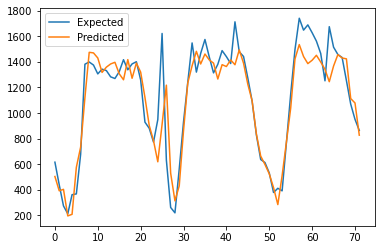

In [98]:
rmse = np.sqrt(mae)
print(rmse)
y_res = y.reset_index(drop=True)
# plot expected vs preducted
plt.plot(y_res, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [190]:
mae, y, yhat = walk_forward_validation(champs_numeric, 72)
print('MAE: %.3f' % mae)

>expected=615.0, predicted=503.2
>expected=439.0, predicted=410.0
>expected=273.0, predicted=276.9
>expected=212.0, predicted=188.7
>expected=361.0, predicted=207.0
>expected=367.0, predicted=584.7
>expected=677.0, predicted=675.4
>expected=1381.0, predicted=1090.1
>expected=1398.0, predicted=1414.5
>expected=1374.0, predicted=1395.2
>expected=1305.0, predicted=1369.8
>expected=1342.0, predicted=1283.0
>expected=1331.0, predicted=1327.5
>expected=1282.0, predicted=1264.6
>expected=1269.0, predicted=1358.0
>expected=1322.0, predicted=1236.3
>expected=1416.0, predicted=1290.3
>expected=1337.0, predicted=1323.6
>expected=1383.0, predicted=1273.3
>expected=1400.0, predicted=1335.2
>expected=1258.0, predicted=1231.4
>expected=928.0, predicted=1018.1
>expected=880.0, predicted=847.0
>expected=772.0, predicted=694.5
>expected=948.0, predicted=655.0
>expected=1621.0, predicted=906.3
>expected=631.0, predicted=1237.0
>expected=261.0, predicted=527.4
>expected=219.0, predicted=350.3
>expected=56

176.4607910155455


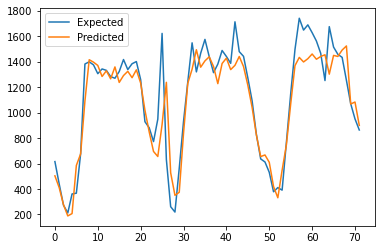

In [191]:
rmse = np.sqrt(mae)
print(rmse)
y_res = y.reset_index(drop=True)
# plot expected vs preducted
plt.plot(y_res, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

134.6733053933984


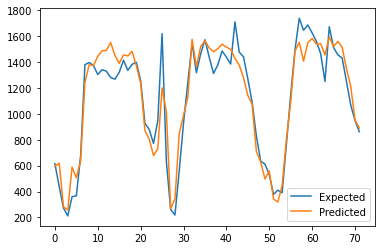

In [179]:
champs_numeric = champs.drop(columns=['Libelle', 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week'], errors='ignore')

champs_numeric = pd.get_dummies(champs_numeric, columns=['Etat arc', 'Etat trafic'], drop_first=True)

train, test = champs_numeric.iloc[:-72, :], champs_numeric.iloc[-72:, :]

trainX, trainy = train.loc[:, train.columns != 'Débit horaire'], train.loc[:, ['Débit horaire']]
testX, testy = test.loc[:, test.columns != 'Débit horaire'], test.loc[:, ['Débit horaire']]


trainX = np.asarray(trainX)
trainy = np.asarray(trainy)
testX = np.asarray(testX)
testy = np.asarray(testy)

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

yhat = model.predict(testX)

error = mean_squared_error(testy, yhat)

rmse = np.sqrt(error)
print(rmse)
# plot expected vs preducted
plt.plot(testy, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()


In [180]:
print(champs_numeric.columns)

Index(['Unnamed: 0', 'Débit horaire', 'Taux d'occupation',
       'Identifiant noeud amont', 'Identifiant noeud aval', 'holiday_period',
       'is_holiday', 'chantiers1', 'chantiers_pertu1',
       'Niveau de perturbation', 'Statut', 'temp', 'humidity', 'visibility',
       'Variation de pression en 24 heures',
       'Précipitations dans les 24 dernières heures', 'rain', 'atm_pressure',
       'wind_speed', 'events1', 'short_event', 'long_event', 'number_markets',
       'ongoing_market', 'cos_week', 'sin_week', 'cos_weekday', 'sin_weekday',
       'cos_year_day', 'sin_year_day', 'cos_timestamp_hour',
       'sin_timestamp_hour', 'Etat arc_Invalide', 'Etat trafic_Fluide',
       'Etat trafic_Inconnu', 'Etat trafic_Pré-saturé', 'Etat trafic_Saturé'],
      dtype='object')


152.65536858092622


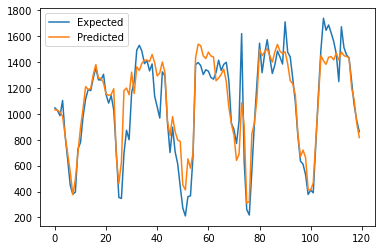

In [192]:
champs_numeric = champs.drop(columns=['Libelle', 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week'], errors='ignore')

champs_numeric = pd.get_dummies(champs_numeric, columns=['Etat arc', 'Etat trafic'], drop_first=True)

train, test = champs_numeric.iloc[:-120, :], champs_numeric.iloc[-120:, :]

trainX, trainy = train.loc[:, train.columns != 'Débit horaire'], train.loc[:, ['Débit horaire']]
testX, testy = test.loc[:, test.columns != 'Débit horaire'], test.loc[:, ['Débit horaire']]


trainX = np.asarray(trainX)
trainy = np.asarray(trainy)
testX = np.asarray(testX)
testy = np.asarray(testy)

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

yhat = model.predict(testX)

error = mean_squared_error(testy, yhat)

rmse = np.sqrt(error)
print(rmse)
# plot expected vs preducted
plt.plot(testy, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()